# Agglomerative Clustering con FFT

Clustering jerárquico usando las mismas features espectrales del notebook K-Means.

**Referencia:** Ver `2_clustering_fft_kmeans.ipynb` para detalles de carga de datos y extracción de features.

In [8]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 6]

# Utilidades
sys.path.append('../utils')
from clustering_utils import load_paired_signals_for_clustering, apply_fft_to_pairs, extract_simple_spectral_features
from metrics_logger import ClusteringMetricsLogger

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Logger
RESULTS_FILE = '../../results/clustering_experiments.csv'
logger = ClusteringMetricsLogger(output_file=RESULTS_FILE)

print("Setup completado")

Setup completado


## 1. Carga de Datos y Features

In [9]:
# Cargar pares (S2, S1) -> FFT -> Features -> Normalizar
paired_data = load_paired_signals_for_clustering(
    signals_dir='../../data/Signals_Raw/',
    labels_csv='../../data/nivel_damage.csv',
    base_specimens_only=True,
    target_length=60000,
    verbose=False
)

fft_data = apply_fft_to_pairs(paired_data, sampling_rate=100)
features_matrix, features_df, feature_names = extract_simple_spectral_features(fft_data, freq_range=(0, 20))

# Normalizar
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_matrix)

# Metadata
labels_real = features_df['nivel_dano'].values
specimen_ids = features_df['specimen_id'].values

# Para metricas extrinsecas (solo etiquetados)
label_mapping = {'N1': 0, 'N2': 1, 'N3': 2}
mask_con_etiqueta = labels_real != 'Sin_etiqueta'
labels_real_numeric = np.array([label_mapping[l] for l in labels_real[mask_con_etiqueta]])

print(f"Datos: {features_normalized.shape[0]} especimenes x {features_normalized.shape[1]} features")
print(f"Etiquetados: {mask_con_etiqueta.sum()} de {len(labels_real)}")

🔄 PASO 2: Aplicando FFT a cada par (S2, S1)...
   ✓ A1: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A10: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A11: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A12: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A13: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A14: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A15: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A16: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A17: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.001

## 2. Dendrograma

El **dendrograma** visualiza la jerarquia de agrupamiento. El eje Y muestra la distancia a la que se fusionan los clusters. Cortando horizontalmente podemos elegir el numero de clusters.

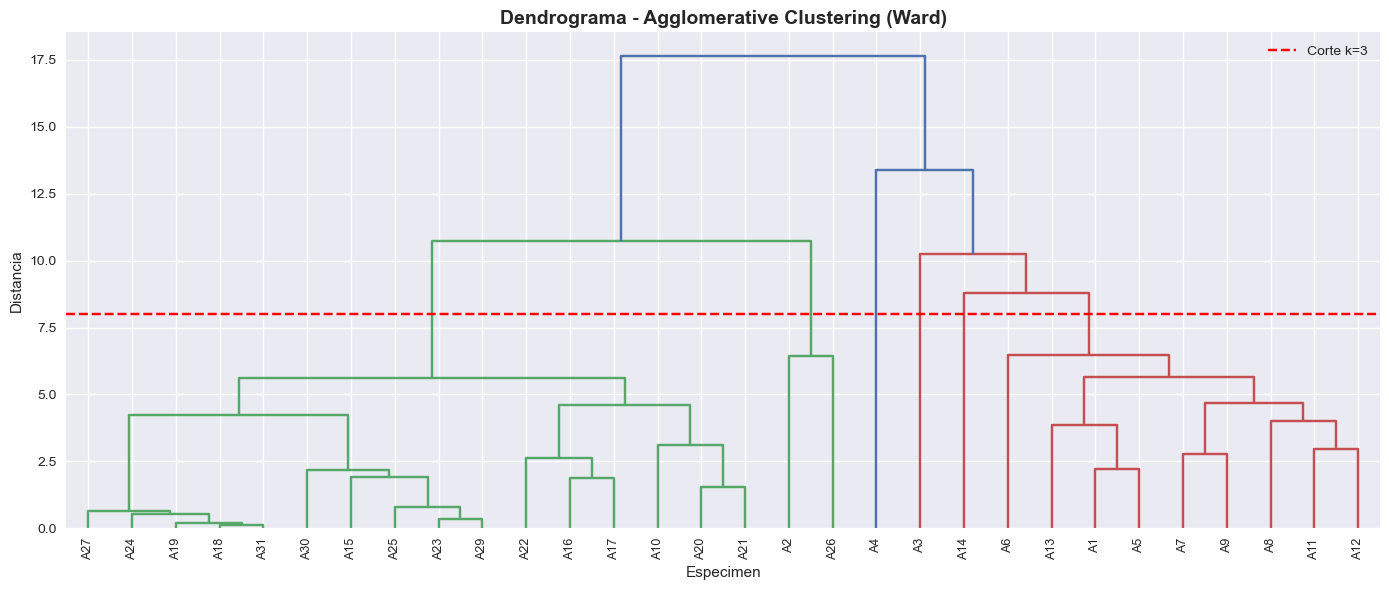

In [10]:
# Calcular linkage (Ward minimiza varianza intra-cluster)
Z = linkage(features_normalized, method='ward')

# Graficar dendrograma
plt.figure(figsize=(14, 6))
dendrogram(Z, labels=specimen_ids, leaf_rotation=90, leaf_font_size=9)
plt.axhline(y=8, color='red', linestyle='--', label='Corte k=3')
plt.title('Dendrograma - Agglomerative Clustering (Ward)', fontsize=14, fontweight='bold')
plt.xlabel('Especimen')
plt.ylabel('Distancia')
plt.legend()
plt.tight_layout()
plt.show()

## 3. Agglomerative Clustering (k=3, Ward)

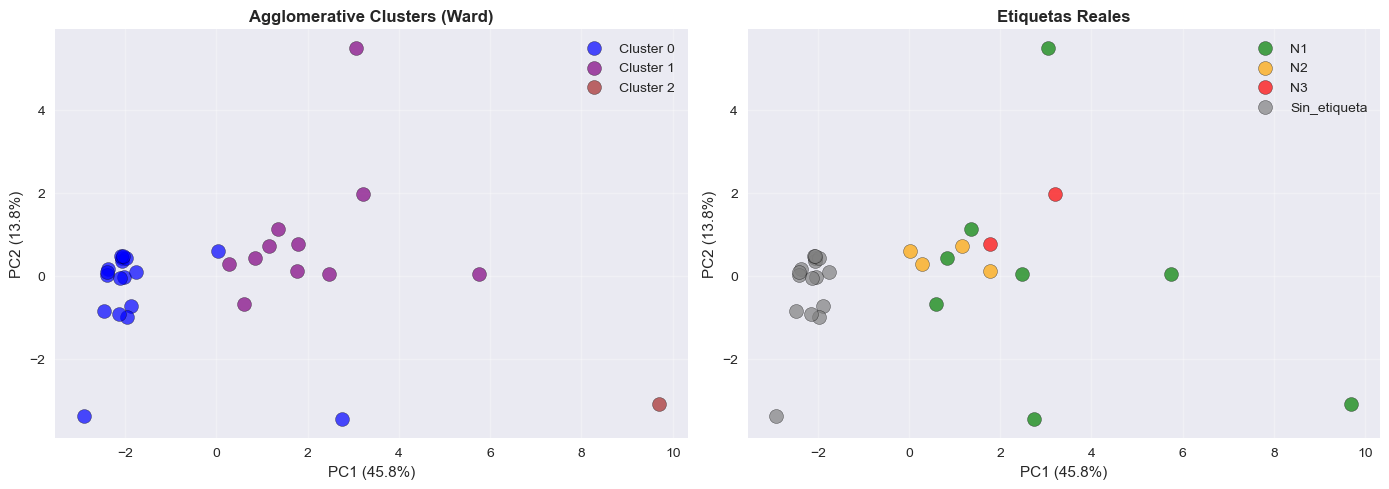


Cluster vs Nivel de Dano:
Cluster        0  1  2
Nivel                 
N1             1  6  1
N2             1  3  0
N3             0  2  0
Sin_etiqueta  16  0  0


In [11]:
# Aplicar clustering
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
cluster_labels = agg.fit_predict(features_normalized)

# PCA para visualizacion
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_normalized)

# Visualizacion
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Clusters
colors_cluster = {0: 'blue', 1: 'purple', 2: 'brown'}
for c in range(3):
    mask = cluster_labels == c
    axes[0].scatter(features_pca[mask, 0], features_pca[mask, 1], 
                    c=colors_cluster[c], label=f'Cluster {c}', s=100, alpha=0.7, edgecolors='black')
axes[0].set_title('Agglomerative Clusters (Ward)', fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Etiquetas reales
colors_real = {'N1': 'green', 'N2': 'orange', 'N3': 'red', 'Sin_etiqueta': 'gray'}
for nivel in ['N1', 'N2', 'N3', 'Sin_etiqueta']:
    mask = labels_real == nivel
    if mask.sum() > 0:
        axes[1].scatter(features_pca[mask, 0], features_pca[mask, 1],
                        c=colors_real[nivel], label=nivel, s=100, alpha=0.7, edgecolors='black')
axes[1].set_title('Etiquetas Reales', fontweight='bold')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla de contingencia
print("\nCluster vs Nivel de Dano:")
print(pd.crosstab(labels_real, cluster_labels, rownames=['Nivel'], colnames=['Cluster']))

## 4. Metricas y Registro

In [12]:
# Metricas intrinsecas
silhouette = silhouette_score(features_normalized, cluster_labels)
davies_bouldin = davies_bouldin_score(features_normalized, cluster_labels)
calinski = calinski_harabasz_score(features_normalized, cluster_labels)

# Metricas extrinsecas (solo etiquetados)
cluster_labels_etiq = cluster_labels[mask_con_etiqueta]
ari = adjusted_rand_score(labels_real_numeric, cluster_labels_etiq)
nmi = normalized_mutual_info_score(labels_real_numeric, cluster_labels_etiq)
homogeneity = homogeneity_score(labels_real_numeric, cluster_labels_etiq)
completeness = completeness_score(labels_real_numeric, cluster_labels_etiq)
v_measure = v_measure_score(labels_real_numeric, cluster_labels_etiq)

print("Metricas Agglomerative (Ward, k=3):")
print(f"  Silhouette:     {silhouette:.4f}")
print(f"  Davies-Bouldin: {davies_bouldin:.4f}")
print(f"  Calinski:       {calinski:.2f}")
print(f"  ARI:            {ari:.4f}")
print(f"  NMI:            {nmi:.4f}")

# Registrar
logger.log_experiment(
    experiment_id="fft_agglomerative_k3_ward",
    notebook_name="3_clustering_fft_agglomerative",
    algorithm="agglomerative",
    frequency_transform="fft",
    n_clusters=3,
    pca_dims=2,
    feature_set="simple_spectral",
    silhouette_score=silhouette,
    davies_bouldin_index=davies_bouldin,
    calinski_harabasz_score=calinski,
    adjusted_rand_index=ari,
    normalized_mutual_info=nmi,
    homogeneity=homogeneity,
    completeness=completeness,
    v_measure=v_measure,
    n_samples=len(features_normalized),
    n_features=features_normalized.shape[1],
    notes="Agglomerative Ward linkage k=3"
)

Metricas Agglomerative (Ward, k=3):
  Silhouette:     0.3010
  Davies-Bouldin: 1.0492
  Calinski:       11.24
  ARI:            -0.1059
  NMI:            0.0930
📊 Experimento registrado: 3_clustering_fft_agglomerative | agglomerative | fft (ID: fft_agglomerative_k3_ward)


## 5. Comparacion de Linkages

Comparamos 3 metodos de linkage:
- **Ward**: Minimiza varianza intra-cluster (mejor para clusters esfericos)
- **Complete**: Distancia maxima entre puntos de clusters
- **Average**: Distancia promedio entre puntos

In [13]:
linkages = ['ward', 'complete', 'average']
results = []

for link in linkages:
    agg_tmp = AgglomerativeClustering(n_clusters=3, linkage=link)
    labels_tmp = agg_tmp.fit_predict(features_normalized)
    
    sil = silhouette_score(features_normalized, labels_tmp)
    db = davies_bouldin_score(features_normalized, labels_tmp)
    ch = calinski_harabasz_score(features_normalized, labels_tmp)
    
    labels_tmp_etiq = labels_tmp[mask_con_etiqueta]
    ari_tmp = adjusted_rand_score(labels_real_numeric, labels_tmp_etiq)
    nmi_tmp = normalized_mutual_info_score(labels_real_numeric, labels_tmp_etiq)
    
    results.append({
        'Linkage': link,
        'Silhouette': sil,
        'Davies-Bouldin': db,
        'Calinski': ch,
        'ARI': ari_tmp,
        'NMI': nmi_tmp
    })
    
    # Registrar cada linkage
    logger.log_experiment(
        experiment_id=f"fft_agglomerative_k3_{link}",
        notebook_name="3_clustering_fft_agglomerative",
        algorithm="agglomerative",
        frequency_transform="fft",
        n_clusters=3,
        pca_dims=2,
        feature_set="simple_spectral",
        silhouette_score=sil,
        davies_bouldin_index=db,
        calinski_harabasz_score=ch,
        adjusted_rand_index=ari_tmp,
        normalized_mutual_info=nmi_tmp,
        n_samples=len(features_normalized),
        n_features=features_normalized.shape[1],
        notes=f"Agglomerative {link} linkage k=3"
    )

# Mostrar tabla comparativa
df_results = pd.DataFrame(results)
print("\nComparacion de Linkages:")
print(df_results.to_string(index=False))

🔄 Experimento actualizado: 3_clustering_fft_agglomerative | agglomerative | fft (ID: fft_agglomerative_k3_ward)
📊 Experimento registrado: 3_clustering_fft_agglomerative | agglomerative | fft (ID: fft_agglomerative_k3_complete)
📊 Experimento registrado: 3_clustering_fft_agglomerative | agglomerative | fft (ID: fft_agglomerative_k3_average)

Comparacion de Linkages:
 Linkage  Silhouette  Davies-Bouldin  Calinski       ARI      NMI
    ward    0.301011        1.049221 11.237806 -0.105939 0.093013
complete    0.408000        1.066396  8.917675 -0.063439 0.169696
 average    0.443945        0.357702  7.325871 -0.134763 0.121217


In [14]:
print(f"\nExperimentos registrados en: {RESULTS_FILE}")
print("\nPara comparar con K-Means:")
print("  pd.read_csv(RESULTS_FILE)")


Experimentos registrados en: ../../results/clustering_experiments.csv

Para comparar con K-Means:
  pd.read_csv(RESULTS_FILE)
